<a href="https://colab.research.google.com/github/eissana/transformer/blob/master/transformer_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"running on: {device}")

running on: cuda


In [4]:
with urlopen('https://raw.githubusercontent.com/eissana/transformer/master/data/shahname.txt') as f:
    words = f.read().decode('utf-8')
print(f'First few lines:\n {words[:200]}')

First few lines:
 چو ترکان بدیدند کارجاسپ رفت	همی آید از هر سوی تیغ تفت
همه سرکشانشان پیاده شدند	به پیش گو اسفندیار آمدند
کمانچای چاچی بینداختند	قبای نبردی برون آختند
به زاریش گفتند گر شهریار	دهد بندگان را به جان زینها


In [6]:
print(f'Number of characters: {len(words)}')

Number of characters: 2555369


In [7]:
chars = sorted(set(words))
nchars = len(chars)
# includes \n (new line), space, numbers and letters.
print(f'{nchars = }')
','.join(chars)

nchars = 48


'\t,\n, ,(,),«,»,،,؟,ء,آ,أ,ؤ,ئ,ا,ب,ت,ث,ج,ح,خ,د,ذ,ر,ز,س,ش,ص,ض,ط,ظ,ع,غ,ف,ق,ل,م,ن,ه,و,ٔ,پ,چ,ژ,ک,گ,ی,\u200c'

In [8]:
atoi = {c: i for i, c in enumerate(chars)}
itoa = {i: c for i, c in enumerate(chars)}

In [9]:
def encode(str):
    return [atoi[c] for c in str]

def decode(arr):
    return ''.join([itoa[i] for i in arr])

str = words[:104]
enc = encode(str)
print(enc)
print(decode(enc))

[42, 39, 2, 16, 23, 44, 14, 37, 2, 15, 21, 46, 21, 37, 21, 2, 44, 14, 23, 18, 14, 25, 41, 2, 23, 33, 16, 0, 38, 36, 46, 2, 10, 46, 21, 2, 14, 24, 2, 38, 23, 2, 25, 39, 46, 2, 16, 46, 32, 2, 16, 33, 16, 1, 38, 36, 38, 2, 25, 23, 44, 26, 14, 37, 26, 14, 37, 2, 41, 46, 14, 21, 38, 2, 26, 21, 37, 21, 0, 15, 38, 2, 41, 46, 26, 2, 45, 39, 2, 14, 25, 33, 37, 21, 46, 14, 23, 2, 10, 36, 21, 37, 21, 1]
چو ترکان بدیدند کارجاسپ رفت	همی آید از هر سوی تیغ تفت
همه سرکشانشان پیاده شدند	به پیش گو اسفندیار آمدند



In [10]:
encdata = torch.tensor(encode(words), dtype=torch.long)
print(encdata[:104])

tensor([42, 39,  2, 16, 23, 44, 14, 37,  2, 15, 21, 46, 21, 37, 21,  2, 44, 14,
        23, 18, 14, 25, 41,  2, 23, 33, 16,  0, 38, 36, 46,  2, 10, 46, 21,  2,
        14, 24,  2, 38, 23,  2, 25, 39, 46,  2, 16, 46, 32,  2, 16, 33, 16,  1,
        38, 36, 38,  2, 25, 23, 44, 26, 14, 37, 26, 14, 37,  2, 41, 46, 14, 21,
        38,  2, 26, 21, 37, 21,  0, 15, 38,  2, 41, 46, 26,  2, 45, 39,  2, 14,
        25, 33, 37, 21, 46, 14, 23,  2, 10, 36, 21, 37, 21,  1])


In [11]:
nencdata = len(encdata)
ntrain, nvalid = int(0.8*nencdata), int(0.1*nencdata)

data = {'train': encdata[:ntrain],
        'valid': encdata[ntrain:ntrain+nvalid],
        'test': encdata[ntrain+nvalid:]}

print('Data split: ', end='')
print(f"{nencdata} = {len(data['train'])} + {len(data['valid'])} + {len(data['test'])}")

Data split: 2555369 = 2044295 + 255536 + 255538


In [12]:
nembd = 384
nhead = 6
nblock = 6
dropout = 0.3

nbatch = 64
block_size = 256

nepoch = 5000
eval_size = 500
lr = 3e-4

In [13]:
def get_batch(data, nbatch, block_size):
    '''
    Generates a batch of examples.
    (x[i], y[i]) is a pair of consecutive characters in the text.
    '''
    indices = torch.randint(len(data)-block_size, (nbatch,))
    x = torch.stack([data[i:i+block_size] for i in indices]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in indices]).to(device)
    return x, y

In [14]:
x, y = get_batch(data['train'], nbatch=2, block_size=8)
x, y

(tensor([[ 2, 41, 46, 26,  2, 21, 23,  2],
         [14,  0, 42, 38,  2, 45, 39, 46]], device='cuda:0'),
 tensor([[41, 46, 26,  2, 21, 23,  2, 10],
         [ 0, 42, 38,  2, 45, 39, 46, 46]], device='cuda:0'))

In [15]:
def get_loss(logits, y):
    '''
    Computes cross-entropy loss, given logits and labels.
    '''
    B, T, C = logits.shape
    # F.cross_entropy expects size C, (B, C), or (B, C, ...)
    # logits shape is (B, T, C), so we flatten the first two dimensions.
    return F.cross_entropy(logits.view(B*T, C), y.view(B*T))

In [16]:
def train(model, data, nepoch=100, nbatch=20, block_size=8, lr=1e-3, losses=None):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    if losses is None:
        losses = {
            'train': [],
            'valid': [],
        }
    for _ in range(nepoch):
        x, y = get_batch(data['train'], nbatch=nbatch, block_size=block_size)

        logits = model(x)
        loss = get_loss(logits, y)
        losses['train'].append(loss.item())

        with torch.no_grad():
            x, y = get_batch(data['valid'], nbatch=nbatch, block_size=block_size)
            logits = model(x)
            vloss = get_loss(logits, y)
            losses['valid'].append(vloss.item())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return losses

In [17]:
def gen_text(model, block_size, max_size=100):
    '''
    Generates text using the model starting from nothing.
    '''
    # starting from '\n' char we generate text.
    x = torch.zeros((1, 1), dtype=torch.long, device=device)
    for _ in range(max_size):
        logits = model(x[:, -block_size:])
        # only consider the last logit
        logits = logits[:, -1, :]
        score = F.softmax(logits, dim=1)
        next_token = score.multinomial(1)
        x = torch.cat((x, next_token), dim=1)
    return x[0].tolist()

In [18]:
def nparameters(model):
    '''
    Returns the total number of model parameters.
    '''
    return sum([p.nelement() for p in model.parameters()])

In [19]:
class Head(nn.Module):
    '''
    Self-attention head layer.
    '''
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(nembd, head_size, bias=False)
        self.key = nn.Linear(nembd, head_size, bias=False)
        self.value = nn.Linear(nembd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        # tril is not a model parameter so we register it as a buffer.
        # block_size is the maximum size. The actual size can be smaller.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        _, T, C = x.shape
        query = self.query(x)
        key = self.key(x)
        weights = query @ key.transpose(-2, -1) * C**-0.5

        # The time dimension can be smaller than the block-size.
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        value = self.value(x)
        out = weights @ value

        return out

In [20]:
class MultiHead(nn.Module):
    def __init__(self, nhead, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(nhead)])
        self.proj = nn.Linear(nembd, nembd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

In [21]:
class FeedForward(nn.Module):
    def __init__(self, fain_in, fan_out):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(fain_in, 4 * fan_out),
            nn.ReLU(),
            nn.Linear(4 * fan_out, fan_out),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        out = self.ff(x)
        return out

In [22]:
class Block(nn.Module):
    def __init__(self, nembd, nhead):
        super().__init__()
        # self-attention heads
        self.sa = MultiHead(nhead, nembd//nhead)
        self.sa_layer_norm = nn.LayerNorm(nembd)
        # feed-forward network
        self.ff = FeedForward(nembd, nembd)
        self.ff_layer_norm = nn.LayerNorm(nembd)


    def forward(self, x):
        out = x
        # deep residual network
        out = out + self.sa(self.sa_layer_norm(out))
        out = out + self.ff(self.ff_layer_norm(out))
        return out

In [23]:
class Transformer(nn.Module):
    '''
    A simple transformer model for building a character-level
    language model using multiple self-attention heads.
    '''
    def __init__(self, nhead, nblock):
        super().__init__()
        self.token_emb = nn.Embedding(nchars, nembd)
        self.position_emb = nn.Embedding(block_size, nembd)
        self.blocks = nn.Sequential(*[Block(nembd, nhead) for _ in range(nblock)])
        self.layer_norm = nn.LayerNorm(nembd)
        self.linear = nn.Linear(nembd, nchars)

    def forward(self, x):
        _, T = x.shape
        # x.shape == (nbatch, block_size, nchars)
        # token_emb.shape == (nbatch, block_size, nembd)
        token_emb = self.token_emb(x)
        # position_emb.shape == (nbatch, block_size, nembd)
        position_emb = self.position_emb(torch.arange(T, device=device))
        # out.shape == (nbatch, block_size, nembd)
        out = token_emb + position_emb
        # out.shape == (nbatch, block_size, nembd)
        out = self.blocks(out)
        out = self.layer_norm(out)
        # out.shape == (nbatch, block_size, nchars)
        out = self.linear(out)

        return out

multihead_transformer = Transformer(nhead, nblock).to(device)

In [24]:
nparameters(multihead_transformer)

10775856

In [ ]:
multihead_losses = None

In [ ]:
multihead_losses = train(multihead_transformer, data, nepoch, nbatch, block_size, lr=lr, losses=multihead_losses)

In [ ]:
print(f"final training loss: {np.mean(multihead_losses['train'][-eval_size:])}")
print(f"final validation loss: {np.mean(multihead_losses['valid'][-eval_size:])}")

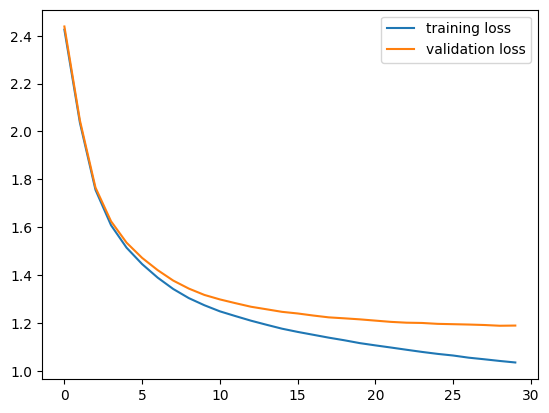

In [ ]:
plt.plot(torch.tensor(multihead_losses['train']).view(-1, eval_size).mean(axis=1));
plt.plot(torch.tensor(multihead_losses['valid']).view(-1, eval_size).mean(axis=1));
plt.legend(['training loss', 'validation loss']);

In [ ]:
print(decode(gen_text(multihead_transformer, block_size, max_size=1000)))